# Processamento Digital de Imagens - Sistema Seletivo de Detecção de Intrusos

Detecção de intrusos que diferencia entre humanos andando por uma área monitorada e os cães de guarda desta área: o sistema deve soar um alarme sempre que um humano aparece caminhando pela cena mas deve ignorar os cães.

## Mount Drive

In [1]:
# Code to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Constants

In [3]:
PATH_IMAGES = "/content/drive/MyDrive/2024/2024 1/Semana Academica/Data/"

## Functions

In [4]:
# Exibir imagens
def show_image(title, image, cmap = None):
    plt.figure(figsize=(6, 6))
    if cmap == "gray":
      plt.imshow(image, cmap = cmap)
    else:
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap = cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Load Images

In [5]:
image_ref = cv2.imread(PATH_IMAGES + "porta1.jpg")
image_larapio = cv2.imread(PATH_IMAGES + "larapio.jpg")
image_cachorro = cv2.imread(PATH_IMAGES + "branquinha3.jpg")

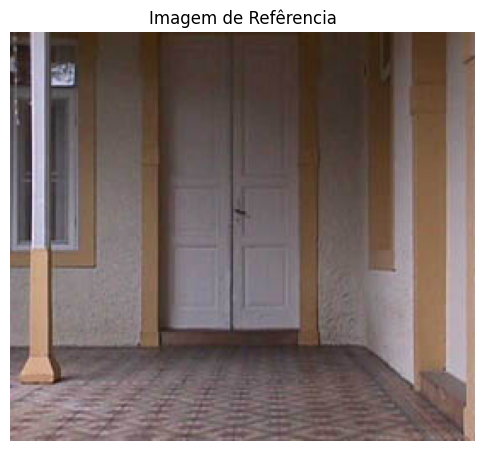

In [6]:
show_image("Imagem de Refêrencia", image_ref)

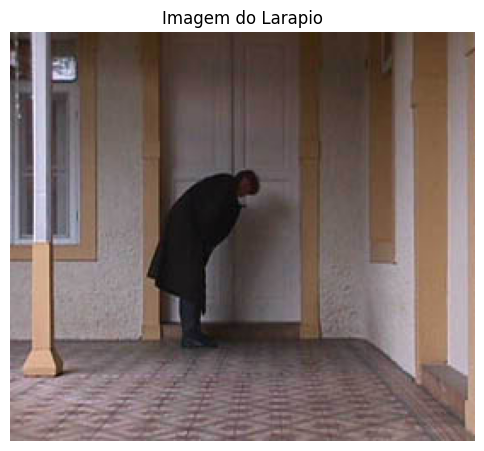

In [7]:
show_image("Imagem do Larapio", image_larapio)

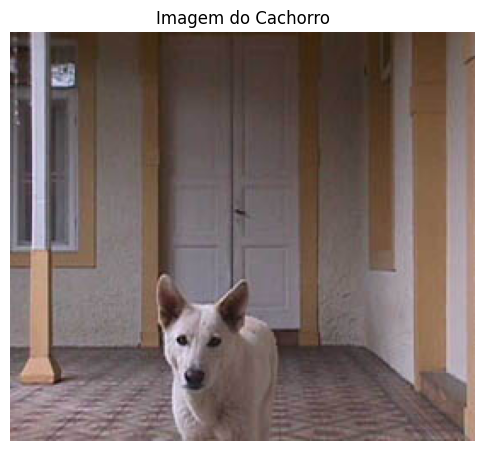

In [8]:
show_image("Imagem do Cachorro", image_cachorro)

## Convert images to grayscale

In [9]:
# Convert images
image_ref_gray = cv2.cvtColor(image_ref, cv2.COLOR_BGR2GRAY)
image_larapio_gray = cv2.cvtColor(image_larapio, cv2.COLOR_BGR2GRAY)
image_cachorro_gray = cv2.cvtColor(image_cachorro, cv2.COLOR_BGR2GRAY)

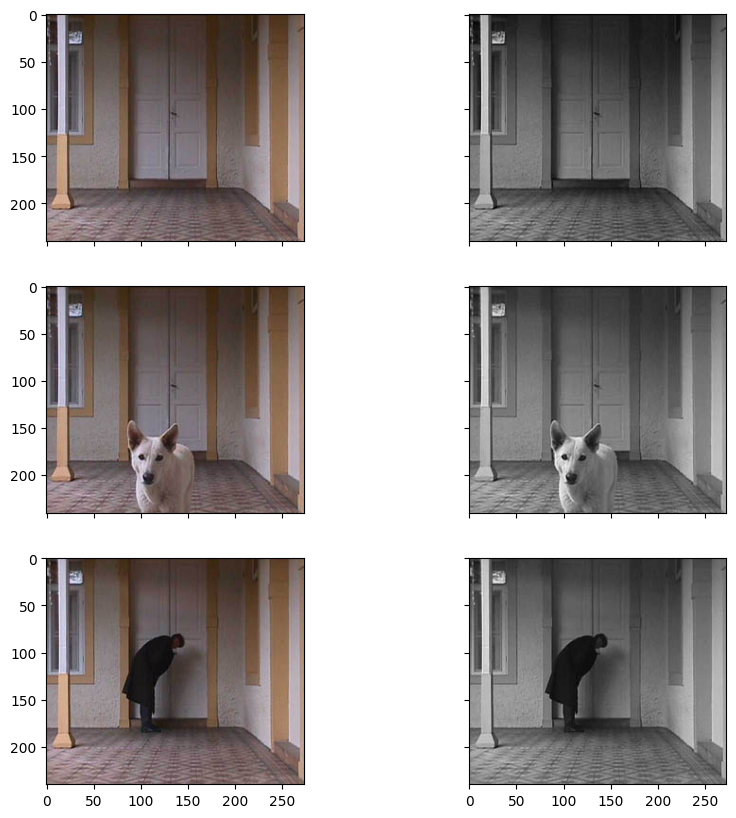

In [10]:
# Show images
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(cv2.cvtColor(image_ref, cv2.COLOR_BGR2RGB))
ax[1].imshow(image_ref_gray, 'gray')
ax[2].imshow(cv2.cvtColor(image_cachorro, cv2.COLOR_BGR2RGB))
ax[3].imshow(image_cachorro_gray, 'gray')
ax[4].imshow(cv2.cvtColor(image_larapio, cv2.COLOR_BGR2RGB))
ax[5].imshow(image_larapio_gray, 'gray')
fig.show()

## Detectando Diferenças entre Imagem-Modelo e Imagem Atual geradas por Movimento na Cena

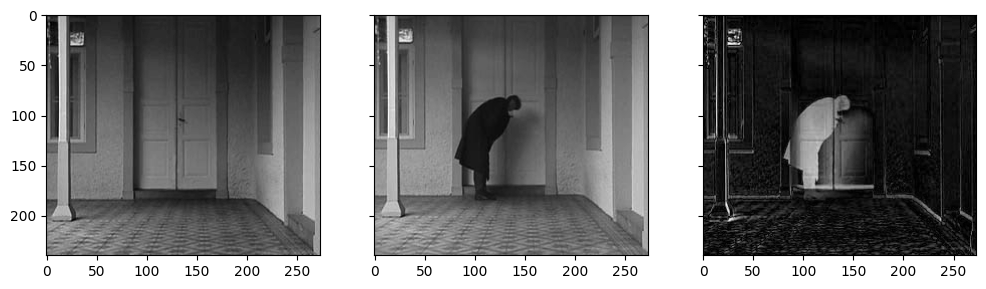

In [11]:
# Calculate the absolute difference between two images
# Image order is irrelevant since we will discard the sign
image_larapio_change = cv2.absdiff(image_larapio_gray, image_ref_gray)

fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image_ref_gray, 'gray')
ax[1].imshow(image_larapio_gray, 'gray')
ax[2].imshow(image_larapio_change, 'gray')
fig.show()

## Thresholding Image Binary

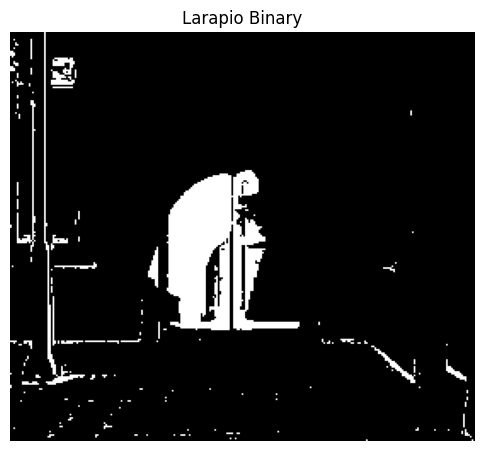

In [12]:
_, image_larapio_binary = cv2.threshold(image_larapio_change, 50, 255, cv2.THRESH_BINARY)
show_image("Larapio Binary", image_larapio_binary, 'gray')

## Eliminando Ruídos gerados por Movimento da Câmera e Isolando os Objetos  através de Morfologia Matemática

In [13]:
# Horizontal Kernel
kernel = np.ones((1,5),np.uint8)
kernel

array([[1, 1, 1, 1, 1]], dtype=uint8)

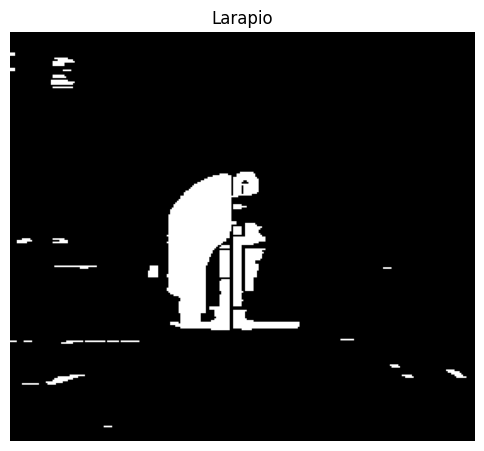

In [14]:
image_larapio_opening = cv2.morphologyEx(image_larapio_binary, cv2.MORPH_OPEN, kernel)
show_image("Larapio", image_larapio_opening, 'gray')

Imagem após operação morfológica de abertura com kernel horizontal longo e fino para eliminação de linhas verticais perdidas na cena.

In [15]:
# Vertical Kernel
kernel = np.ones((5,1),np.uint8)
kernel

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

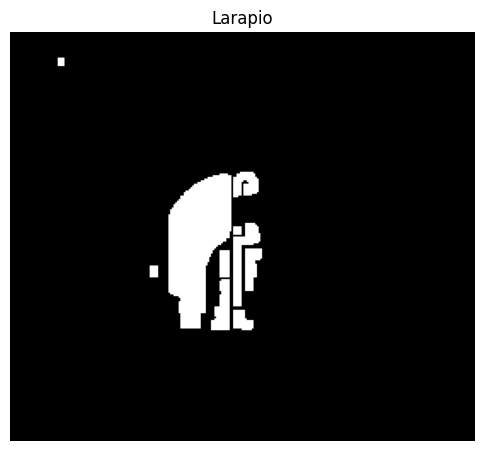

In [16]:
image_larapio_opening = cv2.morphologyEx(image_larapio_opening, cv2.MORPH_OPEN, kernel)
show_image("Larapio", image_larapio_opening, 'gray')

Imagem após operação morfológica de abertura com kernel vertical longo e fino para eliminação de linhas horizontais perdidas na cena.

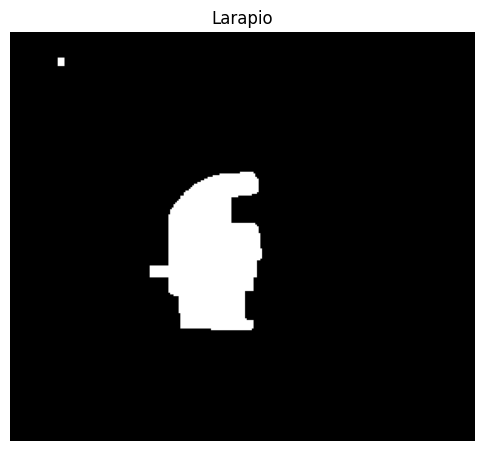

In [17]:
# Executar um fechamento com um Kernel generoso
kernel_close = np.ones((15,15),np.uint8)

image_larapio_closing = cv2.morphologyEx(image_larapio_opening, cv2.MORPH_CLOSE, kernel_close)
show_image("Larapio", image_larapio_closing, cmap = "gray")

Imagem após operação morfológica de fechamento com kernel grande para eliminação de divisões dos objetos da cena. Em muitos casos a sombra do objeto é integrada

## Calculando Atributos dos Objetos para Realizar a Classificação dos Mesmos

Depois de encontrar um conjunto de passos de processamento para filtrar suficientemente a imagem para conseguir separar e tornar conexo o objeto de interesse (e mais alguns outros objetos) do resto da imagem, o próximo passo é gerar uma descrição desses objetos, de forma a que possamos classificá-los adequadamente e, caso necessário, reagir a uma situação onde um intruso foi detectado.

Para realizar isto, nós vamos tomar a imagem resultante da última operação do passo anterior, o fechamento, e proceder com as seguintes operações:

1. Realizar uma rotulação das componentes conexas resultantes do fechamento, identificando cada componente como um objeto separado.

2. Gerar um conjunto de atributos descritores para cada uma dos objetos encontrados. Estes atributos devem ser significativos e descrever características importantes dos objetos, tais como posição de seu centróide, bounding box, componentes principais, inclinação, etc. É neste passo que nós vamos gerar um padrão para ser reconhecido.

3. Analisar estes atributos para ver quais são característicos os suficiente para cada grupo para serem usados para alimentar um classificador de nossa escolha. Por fim vamos escolher um classificador (rede neural, k-NN, método estatístico, regras, if-then-else programático) para realizar o passo de classificação.

**Ideia: relações de área e altura/largura nos permitem diferenciar entre humanos e cães**

Um humano sempre é grande e tem seu eixo principal na vertical, enquanto que um cão o tem na horizontal (se visto de lado) ou então é pequeno (se visto de frente)....

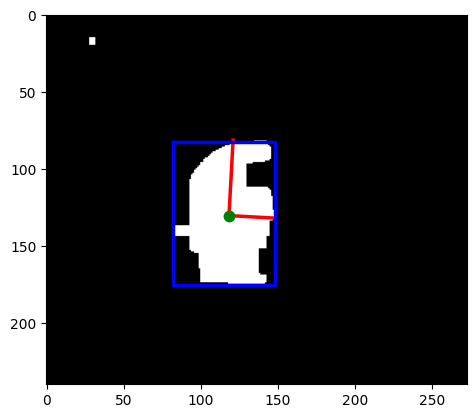

<Figure size 1200x1000 with 0 Axes>

In [18]:
# Propriedades simples de regiões em imagens
# Imagem deve ter uma região bem evidente
# Podemos primeiro extrair as componentes conexas com label(image)
import math
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

# Podemos primeiro identificar as componentes conexas com label()
imagem_rotulada = label(image_larapio_closing)
# Extraímos componentes individuais com regionprops()
regions = regionprops(imagem_rotulada)

# Tomamos a única região
props = regions[1]

fig, ax = plt.subplots()
plt.figure(figsize = (12,10))

ax.imshow(image_larapio_closing, cmap=plt.cm.gray)

# Desenhamos o centróide e os eixos principais
y0, x0 = props.centroid
orientation = props.orientation
x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
ax.plot(x0, y0, '.g', markersize=15)

# Desenhamos o casco convexo
minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-b', linewidth=2.5)


plt.show()

## Referencias

<a href="https://github.com/awangenh/vision/blob/master/jupyter/02.2.Dom%C3%ADnios%20do%20Valor%20e%20Espa%C3%A7o%20-%20Sistema%20Seletivo%20de%20Detec%C3%A7%C3%A3o%20de%20Intrusos.ipynb" target="_blank">Professor Aldo - UFSC</a>